# Project 5: **Vehicle Detection** 




## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


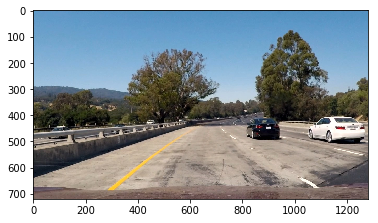

In [2]:
#reading in an image
image = mpimg.imread('test_images/test1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
img_size = image.shape
print(image.shape)
max_x = image.shape[1]
max_y = image.shape[0]

(720, 1280, 3)


## Helper functions

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, px_range=(0, 1.), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Iterate through the list of images
    file_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=px_range)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    features = np.concatenate(file_features)
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Load the training dataset and build the training and testing feature vectors

In this section of the code, we will load the vehicle and non-vehicle images.
The images will then be processed to be converted into a feature vector. 
We will append all the features to a feature vector.Then we will shuffle the data and extract some training and testing data. 

In [12]:
import os
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hog_channel = 0 # can be 0,1,2,or 'ALL'
hist_bins = 32

In [13]:
#create the list to hold the features and the labels
car_feature_list = []
# start with the cars
base_directory = 'vehicles'
subfolder_list = os.listdir(base_directory)

for subfolder in subfolder_list:
    directory = '/'.join([base_directory, subfolder])
    print(directory)
    for filename in os.listdir(directory):
        #print(filename)
        if filename.endswith(".png"): 
            #print(os.path.join(directory, filename))
            img_path = os.path.join(directory, filename)
            # open the image, 
            img = mpimg.imread(img_path) # values range from 0 to 1
            # send the image to the feature extraction functions
            feature = extract_features(img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, px_range=(0, 1.), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
            car_feature_list.append(feature)
            #print(car_feature_list[0].shape)

    #print(car_feature_list[0].shape)
print('number of vehicle images in data set: ', len(car_feature_list))

vehicles/GTI_Left
vehicles/GTI_Right
vehicles/KITTI_extracted
vehicles/GTI_Far
vehicles/GTI_MiddleClose
number of vehicle images in data set:  8792


In [14]:
notcar_feature_list = []

# start with the cars
base_directory = 'non-vehicles'
subfolder_list = os.listdir(base_directory)

for subfolder in subfolder_list:
    directory = '/'.join([base_directory, subfolder])
    print(directory)
    for filename in os.listdir(directory):
        #print(filename)
        if filename.endswith(".png"): 
            #print(os.path.join(directory, filename))
            img_path = os.path.join(directory, filename)
            # open the image, 
            img = mpimg.imread(img_path) # values range from 0 to 1
            # send the image to the feature extraction functions
            feature = extract_features(img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, px_range=(0, 1.), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
            notcar_feature_list.append(feature)
print('number of non vehicle images in data set: ', len(notcar_feature_list))

non-vehicles/GTI
non-vehicles/Extras
number of non vehicle images in data set:  8968


In [15]:
#create the labels
y = np.hstack((np.ones(len(car_feature_list)), np.zeros(len(notcar_feature_list))))

In [16]:
#normalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Create an array stack of feature vectors
X = np.vstack((car_feature_list, notcar_feature_list)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

#shuffle the data
scaled_X, y = shuffle(scaled_X, y)

In [17]:
from sklearn.cross_validation import train_test_split
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

## Train the chosen model

In [18]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

#linear vs rbf ?
#tuning the parameters: C ? G?

#use grid_search.GridSearchCV
#svc  = svm.SVC(kernel = 'rbf', C=1, gamma = 1,  max_iter=1000, verbose=0)
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svc = svm.SVC()
#clf = GridSearchCV(svc, parameters)
#clf.fit(X_train, y_train)

svc  = svm.LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1,
                     loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2',
                     random_state=None, tol=0.0001, verbose=0)

svc.fit(X_train, y_train)

#print(clf.best_params_)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Test the model and its accuracy

In [19]:
accuracy = round(svc.score(X_test, y_test), 4)
print('model accuracy on test data = ',accuracy*100 , '%')

model accuracy on test data =  98.25 %


## Test the model on the test images

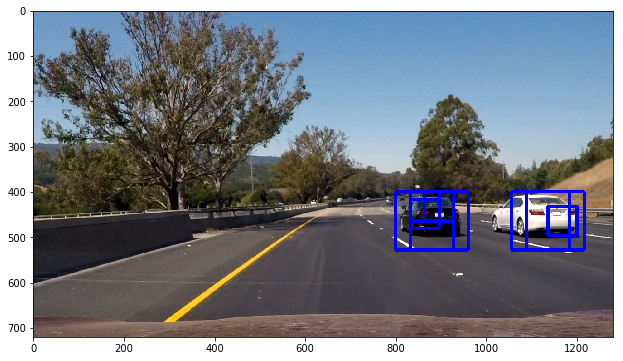

In [214]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

img = mpimg.imread('test_images/test6.jpg')
#print(img.max())
#print(img.min())


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    box_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    for scale in scale_list:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    left_corner = (xbox_left, ytop_draw+ystart)
                    right_corner = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                    if right_corner[0]> 400:
                        box_list.append((left_corner, right_corner))
                        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    return draw_img, box_list
    
ystart = 400
ystop = 656
scale_list = [1,2]
    
out_img1 , bbox = find_cars(img, ystart, ystop, scale_list, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, spatial_size, hist_bins)

fig = plt.figure(figsize=(15, 6))
plt.imshow(out_img1)


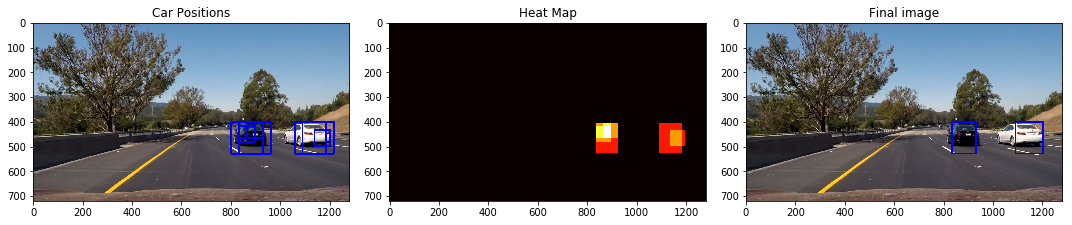

In [543]:
from scipy.ndimage.measurements import label
min_image_for_heatmap = 1

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_boxes_on_image(img, box_list):
    copy_img = np.copy(img)
    # Draw the box on the image
    for box in box_list:
        copy_img = cv2.rectangle(copy_img, box[0], box[1], (0,0,255), 6)
    return copy_img

def bbox_from_labels(labels):
    box_list=[]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox_ = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_list.append(bbox_)
    # Return the image
    return box_list

def get_heat_map(img, boxes, threshold, draw_heatmap=False):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    box_list = bbox_from_labels(labels)
    draw_final_img = draw_labeled_bboxes(np.copy(img), labels)
    if draw_heatmap:
        draw_heatmap = draw_labeled_bboxes(np.copy(heat), labels)
        return box_list, draw_final_img ,draw_heatmap
    else:
        return box_list, draw_final_img
box_list,final_image, heatmap = get_heat_map(img, bbox, min_image_for_heatmap, draw_heatmap = True)

heatmax_wanted = True
if heatmax_wanted:
    fig = plt.figure(figsize=(15, 6))
    plt.subplot(131)
    plt.imshow(out_img1)
    plt.title('Car Positions')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(final_image)
    plt.title('Final image')
    fig.tight_layout()
else:
    fig = plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.imshow(out_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(final_image)
    plt.title('Final image')
    fig.tight_layout()


In [1098]:
import itertools
def point_inside_circle(point, cx, cy, radius):
    a = np.power(point[0]-cx,2)
    b = np.power(point[1]-cy,2)
    r2 = np.power(radius,2)
    #print(a+b)
    return (a+b)< r2

def check_if_box_existed(box, previous_boxes, radius):
    for index, old_box in enumerate(previous_boxes):
        cx_old = (old_box[0][0]+old_box[1][0])/2.
        #print(cx_old)
        cy_old = (old_box[0][1]+old_box[1][1])/2.
        #print(cy_old)
        cx_new = (box[0][0]+box[1][0])/2.
        #print(cx_new)
        cy_new = (box[0][1]+box[1][1])/2.
        #print(cy_new)
        point = (cx_new, cy_new)
        
        if point_inside_circle(point, cx_old, cy_old, radius):
            #print('previous_boxes', previous_boxes)
            #print('index',index)
            return True, index 
    return False, None
def remove_elements_from_list(index_list, box_list):
    new_box_list=[]
    for i, box in enumerate(box_list):
        if i not in index_list:
            new_box_list.append(box)
    return new_box_list


def check_if_multiple_box_for_same_car(box_list, thresh):
    #print('box_list', box_list)
    #get all the permutations of length 2
    c = [x for x in  itertools.permutations(box_list,2)]
    #prepare the list to be returned
    new_box_list = set()
    for boxes in c:
        x1 = (boxes[0][0][0]+boxes[0][1][0])/2.
        #print(cx_old)
        y1 = (boxes[0][0][1]+boxes[0][1][1])/2.
        #print(cy_old)
        x2 = (boxes[1][0][0]+boxes[1][1][0])/2.
        #print(cx_new)
        y2 = (boxes[1][0][1]+boxes[1][1][1])/2.
        dist = np.round(np.sqrt( np.power((x2 - x1),2) + np.power((y2 - y1),2)))
        #print(dist)
        if dist < thresh:
            #combine the boxes
            upper_x_new = min(boxes[0][0][0],boxes[1][0][0])
            upper_y_new = min(boxes[0][0][1],boxes[1][0][1])
            lower_x_new = max(boxes[0][1][0],boxes[1][1][0]) 
            lower_y_new = max(boxes[0][1][1],boxes[1][1][1])
            boxes = [((upper_x_new,upper_y_new),
                       (lower_x_new,lower_y_new))]
            #print(boxes)
        for box in boxes:
            if box not in new_box_list:
                new_box_list.add(box)
    #print('new_list= ',new_box_list)
    return list(new_box_list)

In [1164]:
class Detection():
    def __init__(self):
        # is it the first time we detect a lane?
        self.counter = 0
        # was the line detected in the last iteration?
        self.previous_boxes = None
        # x values of the last n fits of the line
        self.car_missed = 0
        self.countFrame =  None
        self.totalFrame =  0
        self.previous_frames = []


def process_image(img):
    detection.totalFrame+=1
    nframes = 10
    detection.countFrame = detection.totalFrame % nframes 
    _, out_img , _ , _,_ = process_image_heatmap(img, detection)
    detection.car_missed = car_missed
    if detection.car_missed == 0:
        detection.previous_boxes = final_boxes
    else:
        detection.counter+=1
        if detection.counter > 40:
            detection.counter = 0
            detection.car_missed = 0
            detection.previous_boxes = final_boxes
    
    return out_img

def process_image_heatmap(img, detection_tracker):
    previous_box_list = detection_tracker.previous_boxes
    car_missed = detection_tracker.car_missed
    counter = detection_tracker.counter
    #find all the boxes
    min_image_for_heatmap = 1
    scale_list = [1, 1.7] #[1,1.7]
    out_img , bbox = find_cars(img, ystart, ystop, scale_list, svc,
                               X_scaler, orient, pix_per_cell,
                               cell_per_block, spatial_size,
                               hist_bins)
    #reject outliers and get final image
    box_list,final_image, heatmap = get_heat_map(img, bbox, min_image_for_heatmap, draw_heatmap = True)
    #print(box_list)
    if len(box_list)>1:
            box_list = check_if_multiple_box_for_same_car(box_list, 100)
    number_cars_detected = len(box_list)
    if previous_box_list is not None:
        number_cars_previously_detected=len(previous_box_list)
    else:
        number_cars_previously_detected = number_cars_detected
    #print('car previously detected:',number_cars_previously_detected)
    total_detection = 0
    forced_radius = None
    if number_cars_detected == 0 and car_missed!=0:
        number_cars_previously_detected = 1
        forced_radius = 100
        #print('forcing the radius')
    #check we detect the same number of cars than in the previous frame
    #print('total_detection= ',number_cars_detected)
    #print('previous_nb of car = ',number_cars_previously_detected )
    if number_cars_detected < number_cars_previously_detected:
        #print('not enough cars detected')
        #change the parameters to try to improve the detection
        min_image_for_heatmap = 0
        #scale_list = [1,1.5,2]
        scale_list = [1,1.7,2]
        radius = 40
        out_img , bbox = find_cars(img, ystart, ystop, scale_list, svc,
                               X_scaler, orient, pix_per_cell,
                               cell_per_block, spatial_size,
                               hist_bins)
        #reject outliers and get final image
        box_list, final_image, heatmap = get_heat_map(img, bbox, min_image_for_heatmap, draw_heatmap = True)
        #merge the boxes that are close to one another
        if len(box_list)>1:
            box_list = check_if_multiple_box_for_same_car(box_list, 90)
        final_box_list = []
        other_box_list=[]
        toBeRemoved_index_list=[]
        for box in box_list:
            #print('first_search has boxes')
            box_existed , index  =  check_if_box_existed(box,previous_box_list, radius)
            if box_existed:
                toBeRemoved_index_list.append(index)
                total_detection +=1
                final_box_list.append(box)
            else:
                other_box_list.append(box)
        if total_detection==number_cars_previously_detected :
            if final_box_list:
                final_image = draw_boxes_on_image(img, final_box_list)
                car_missed = 0
        else:
            #print('second search')
            #remove the cars detected above
            previous_box_list = remove_elements_from_list(toBeRemoved_index_list,previous_box_list)
            #search with new parameters
            min_image_for_heatmap = 0
            scale_list = [0.9,1.3,1.7,2] #[0.9,1.5,1.2,2]
            if forced_radius is None:
                radius = 20
            else:
                radius = forced_radius
            out_img , bbox = find_cars(img, ystart, ystop, scale_list, svc,
                               X_scaler, orient, pix_per_cell,
                               cell_per_block, spatial_size,
                               hist_bins)
            box_list,final_image, heatmap = get_heat_map(img, bbox, min_image_for_heatmap, draw_heatmap = True)
            if len(box_list)>1:
                box_list = check_if_multiple_box_for_same_car(box_list, 90)
            for box in box_list:
                box_existed , index  =  check_if_box_existed(box,previous_box_list, radius)
                if box_existed:
                    total_detection+=1
                    final_box_list.append(box)
            if final_box_list:
                #print('second search final_bow_list =', len(final_box_list))
                final_image = draw_boxes_on_image(img, final_box_list)
            else: final_image = img
            car_missed = number_cars_previously_detected - total_detection
            #print('total_detection= ',total_detection)
            #print('previous_nb of car = ',number_cars_previously_detected )
            #print('final_box_list length =', len(final_box_list))
    else:
        final_box_list = box_list
        car_missed = 0
    
    if detection_tracker.totalFrame < 11:
        #print(final_box_list)
        final_image = draw_boxes_on_image(img, final_box_list)
        detection_tracker.previous_frames.append(final_box_list)
        #print(len(detection_tracker.previous_frames))
    else:
        detection_tracker.previous_frames[detection_tracker.countFrame] = final_box_list
        # add the detection for the 10 previous frames
        all_boxes=[]
        for frame in detection_tracker.previous_frames:
            if frame:
                for box in frame:
                    all_boxes.append(box)
        _,final_image = get_heat_map(img, all_boxes, 3, draw_heatmap = False)
        
    detection_tracker.car_missed = car_missed
    detection_tracker.previous_boxes = final_box_list
    return out_img, final_image, heatmap, final_box_list, car_missed

## Test on Videos

number of cars missed in frame =  0


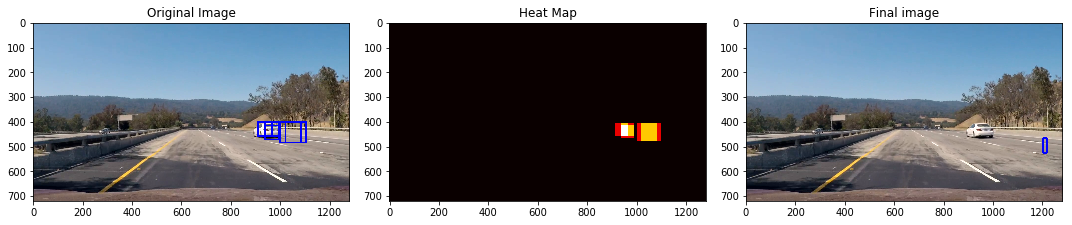

In [1167]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'p.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)
clip1 = VideoFileClip("project_video.mp4")
frame = VideoFileClip("project_video.mp4").get_frame(22)
#detection = Detection()
detection.countFrame = 0
#previous_boxes = None
#car_missed=0
#counter = 0
f_img, out_img , heatmap_img, final_boxes, car_missed = process_image_heatmap(frame, detection)
print('number of cars missed in frame = ', car_missed)
if detection.car_missed == 0:
    detection.previous_boxes = final_boxes
else:
    detection.counter+=1
    if detection.counter > 10:
        detection.counter = 0
        detection.car_missed = 0
        detection.previous_boxes = final_boxes
        
fig = plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(f_img)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(heatmap_img, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(out_img)
plt.title('Final image')
fig.tight_layout()

In [1160]:
print(len(final_boxes))
print (final_boxes)
print('----')
print(len(detection.previous_boxes))
print(detection.previous_boxes)

1
[((928, 400), (991, 463))]
----
1
[((928, 400), (991, 463))]


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [1168]:
detection = Detection()
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video p.mp4
[MoviePy] Writing video p.mp4


100%|█████████▉| 1260/1261 [29:15<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p.mp4 

CPU times: user 30min 27s, sys: 5.68 s, total: 30min 32s
Wall time: 29min 16s
